### Example to show how to get pixel MOLA elevation
#### Currently very brute force
some example code from: http://www.geodose.com/2018/03/create-elevation-profile-generator-python.html

In [1]:
#grab elevation value from Mars WMS elevation service
import math, os
from string import Template

In [34]:
#Function to return elevation in meters from MOLA Web Mapping Server (WMS)
#requires GDAL binaries installed - specifiaclly
# requires: gdallocationinfo
# Although this could also be done in code (using GDAL functions calls).
#
# How this works - The gdal_XML file setups up the WMS service. GDAL acts as if this a local file thus
# one could also simply use gdal_translate to create a local Tiff (or other format). For more info:
# http://planetarygis.blogspot.com/2014/09/tips-to-interact-with-astros-wms-maps.html
# -Trent Hare, thare@usgs.gov

def pointElevationMOLA(lon,lat):

    #setup 1x1 degree tile by flooring the input Lon and Lat
    min_lon = math.floor(lon) 
    max_lon = min_lon +1
    min_lat = math.floor(lat) 
    max_lat = min_lat +1

    #odd workaround for edge
    if  (lon == math.floor(lon)):
        min_lon = min_lon - 0.1
        max_lon = max_lon - 0.1
    if  (lat == math.floor(lat)):
        min_lat = min_lat - 0.1
        max_lat = max_lat - 0.1

    #build this XML file.
    gdal_XML = Template("""<GDAL_WMS>
      <Service name="WMS">
        <Version>1.1.1</Version>
        <ServerUrl>http://wms.wr.usgs.gov/cgi-bin/mapserv?map=/maps/mars/mars_simp_cyl_elev.map</ServerUrl>
        <SRS>EPSG:4326</SRS>
        <ImageFormat>image/tiff</ImageFormat>
        <Layers>MOLA_elev</Layers>
      </Service>
      <DataWindow>
        <UpperLeftX>$minLon</UpperLeftX>
        <UpperLeftY>$maxLat</UpperLeftY>
        <LowerRightX>$maxLon</LowerRightX>
        <LowerRightY>$minLat</LowerRightY>
         <SizeX>128</SizeX>
         <SizeY>128</SizeY>
      </DataWindow>
      <Projection>EPSG:4326</Projection>
      <BandsCount>1</BandsCount>
      <DataType>Int16</DataType>
    </GDAL_WMS>
    """)

    gdal_WMS = gdal_XML.substitute(minLon=min_lon, maxLon=max_lon, minLat=min_lat, maxLat=max_lat)
    xmlFilename = "gdal_WMS.xml"
    outFile = open( xmlFilename ,'w')
    outFile.write( gdal_WMS  )
    outFile.close()

    cmd = "gdallocationinfo -valonly -geoloc %s %s %s" % (xmlFilename, str(lon), str(lat))
    #print(cmd)
    elevValue = os.popen(cmd).read()
    try:
        return int(elevValue)
    except:
        return -9999

In [35]:
molaElev = pointElevationMOLA(280.5,45)
print(molaElev)

1529


### Now let's try a brute force elevation profile

Here we are going to setup a couple more functions - from:
http://www.geodose.com/2018/03/create-elevation-profile-generator-python.html

In [11]:
#HAVERSINE FUNCTION - add variable radius
def haversine(lat1,lon1,lat2,lon2,radius):
   
    lat1_rad=math.radians(lat1)
    lat2_rad=math.radians(lat2)
    lon1_rad=math.radians(lon1)
    lon2_rad=math.radians(lon2)
    delta_lat=lat2_rad-lat1_rad
    delta_lon=lon2_rad-lon1_rad
    a=math.sqrt((math.sin(delta_lat/2))**2+math.cos(lat1_rad)*math.cos(lat2_rad)*(math.sin(delta_lon/2))**2)
    d=2*radius*math.asin(a)
    return d

In [103]:
import matplotlib.pyplot as plt
import requests
from IPython.display import display, Image, SVG, Math, YouTubeVideo

#start and end points -- a diagnal across Olympus Mons
P1=[13,221]
P2=[23,231]

mars_WMS = Template("http://planetarymaps.usgs.gov/cgi-bin/mapserv?map=/maps/mars/mars_simp_cyl.map&SERVICE=WMS&VERSION=1.1.1&SRS=EPSG:4326&STYLES=&REQUEST=GetMap&FORMAT=image%2Fjpeg&LAYERS=MDIM21&BBOX=$lon1,$lat1,$lon2,$lat2&WIDTH=500&HEIGHT=500")
cmd = mars_WMS.substitute(lon1=P1[1], lat1=P1[0], lon2=P2[1],  lat2=P2[0])

#print(cmd)
#marsImage = requests.get(cmd).content


from IPython.display import Image
Image(url=cmd)


In [106]:
#Number of points
s=40
interval_lat=(P2[0]-P1[0])/s #interval for latitude
interval_lon=(P2[1]-P1[1])/s #interval for longitude

#variable for starting point
lat0=P1[0]
lon0=P1[1]

#Latitude and Longitude List
lat_list=[lat0]
lon_list=[lon0]
elev_list=[]

#Gererate list of lat/lons
for i in range(s):
    lat_step=lat0+interval_lat
    lon_step=lon0+interval_lon
    lon0=lon_step
    lat0=lat_step
    lat_list.append(lat_step)
    lon_list.append(lon_step)
    
#Get distances between points
marsRadius = 3396190.0
d_list=[]
for j in range(len(lat_list)):
    lat_p=lat_list[j]
    lon_p=lon_list[j]
    dp=haversine(lat0,lon0,lat_p,lon_p, marsRadius)/1000 #km
    d_list.append(dp)
d_list_rev=d_list[::-1] #reverse list

#Brute force call WMS per point - not optimal by any means!
elev_list=[{}]*len(lat_list)
for i in range(len(lat_list)):
    elev_list[i]=pointElevationMOLA(lon_list[i],lat_list[i])

print(elev_list)

[-1497, -1448, -881, -694, -431, 55, 768, 1582, 2463, 5418, 7472, 8714, 9896, 11218, 12816, 14358, 15596, 17027, 18636, 19871, 20545, 18461, 18114, 18761, 19544, 18568, 16917, 15253, 13802, 12199, 10720, 9246, 7940, 7027, 5796, 1561, 800, 173, -377, -676, -826]


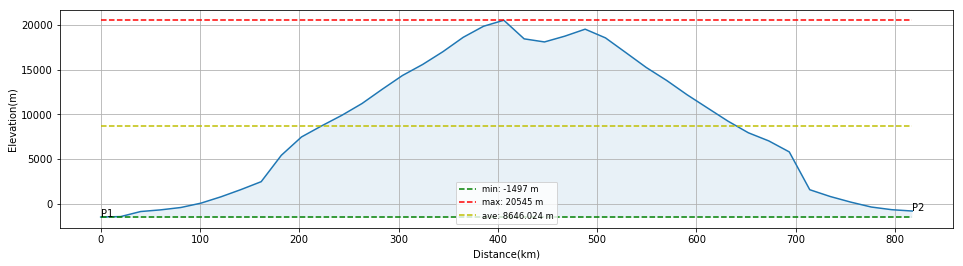

In [108]:
import matplotlib.pyplot as plt

#Stats
mean_elev=round((sum(elev_list)/len(elev_list)),3)
min_elev=min(elev_list)
max_elev=max(elev_list)
distance=d_list_rev[-1]

#Plot Elevation Profile
base_reg=min_elev - 100
plt.figure(figsize=(16,4))
plt.plot(d_list_rev,elev_list)
plt.plot([0,distance],[min_elev,min_elev],'--g',label='min: '+str(min_elev)+' m')
plt.plot([0,distance],[max_elev,max_elev],'--r',label='max: '+str(max_elev)+' m')
plt.plot([0,distance],[mean_elev,mean_elev],'--y',label='ave: '+str(mean_elev)+' m')
plt.fill_between(d_list_rev,elev_list,base_reg,alpha=0.1)
plt.text(d_list_rev[0],elev_list[0],"P1")
plt.text(d_list_rev[-1],elev_list[-1],"P2")
plt.xlabel("Distance(km)")
plt.ylabel("Elevation(m)")
plt.grid()
plt.legend(fontsize='small')
plt.show()